##### Simulation of Single Particle in Trap
Theres no influence of any external perturbation rather than the normal brownian motion. This is made through the same LAMMPS code generation in order to mantain the same rates/scales and so.

In [9]:
import sys
import os
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegFileWriter
import pandas as pd
sys.path.insert(0, './magcolloids')

import magcolloids as mgc
#pint parameter
ureg = mgc.ureg

Settings of the Simulation - No Tilt and The magnitude of the Magnetic Field is 0

In [10]:
region, initial_conditions = mgc.initial_setup(1, packing = 0.3, height = 4, radius = 1.4)
particle_radius = 1.4

particles = mgc.particles(
    initial_conditions*ureg.um,
    radius = particle_radius*ureg.um,
    susceptibility = 0.4,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 1e3*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

stiffness_track = 15e-4

trap_track = mgc.bistable_trap(
                initial_conditions[0:1,:]*ureg.um,
                np.array([[1,0,0]]),
                particles, subsets = [0],
                distance = 0*ureg.um,
                height = 0 * ureg.pN*ureg.nm,
                stiffness = stiffness_track*ureg.pN/ureg.nm)

field = mgc.field(magnitude = 0*ureg.mT, frequency = 3*ureg.Hz, angle = 26.9*ureg.degrees)

world = mgc.world(particles, [trap_track], temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 20*ureg.um)

dir_c = r"./tests/"
f_nam = "single_particle_test"
tot_time = 30

sim = mgc.sim(dir_name = dir_c, file_name = f_nam,
        timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = tot_time*ureg.s,
        particles = particles, traps = [trap_track], world = world, field = field,
        output = ["x","y","z"])

In [11]:
sim.generate_scripts()

In [12]:
sim.run()

CompletedProcess(args=['c:\\Users\\emino\\OneDrive\\Escritorio\\MagColloidStuff\\mgcCode\\magcolloids-master\\magcolloids\\lammps_executables\\lmp_mingw64-native.exe', '-in', './tests/single_particle_test.lmpin'], returncode=0, stdout=b'LAMMPS (18 Jun 2019)\r\nReading data file ...\r\n  orthogonal box = (-2.5 -2.5 -2) to (2.5 2.5 2)\r\n  1 by 1 by 1 MPI processor grid\r\n  reading atoms ...\r\n  2 atoms\r\n  scanning bonds ...\r\n  1 = max bonds/atom\r\n  reading bonds ...\r\n  1 bonds\r\nFinding 1-2 1-3 1-4 neighbors ...\r\n  special bond factors lj:   0          0          0         \r\n  special bond factors coul: 0          0          0         \r\n  1 = max # of 1-2 neighbors\r\n  0 = max # of 1-3 neighbors\r\n  0 = max # of 1-4 neighbors\r\n  1 = max # of special neighbors\r\n  special bonds CPU = 0 secs\r\n  read_data CPU = 0.00101614 secs\r\n1 atoms in group Atoms\r\n1 atoms in group Traps\r\nNeighbor list info ...\r\n  update every 1 steps, delay 1 steps, check yes\r\n  max ne

Visualization of Results

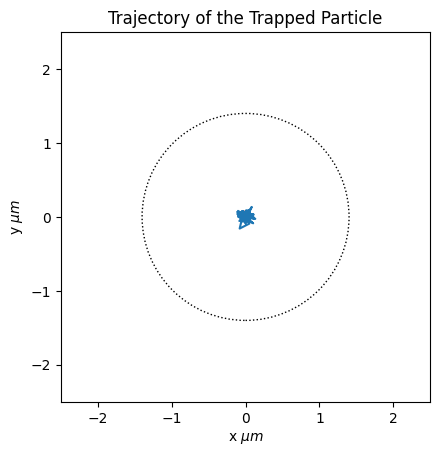

In [13]:
# Load trj
sim.load()
trj = sim.lazy_read[::10]
trj_prime, bounds_df = mgc.load_trj(sim.base_name+".lammpstrj", slice(0,-1,10)) # We get a sample of the bounds, as they not change, we good
bounds = bounds_df.loc[0]
trj_unwrapped = mgc.unwrap_trj(trj.drop(columns=['type']), bounds)

trj_track = trj_unwrapped[trj_unwrapped.index.get_level_values(2) == 1]
x_track = trj_track.x.tolist()
y_track = trj_track.y.tolist()
# Obtaining the time data - frames
fr_track = trj_track.index.get_level_values(1).tolist()

# For circle
fig, ax = plt.subplots(dpi=100)

# Plotting the single trajectory
plt.scatter([x_track[0], x_track[-1]], [y_track[0], y_track[-1]], c='red')
plt.plot(x_track, y_track)
plt.xlabel(r"x $\mu{}m$")
plt.ylabel(r"y $\mu{}m$")
plt.xlim(bounds["x_min"], bounds["x_max"])
plt.ylim(bounds["y_min"], bounds["y_max"])
plt.title("Trajectory of the Trapped Particle")

circle = plt.Circle((x_track[0], y_track[0]), particle_radius, color='black', fill=False, linestyle='dotted')
ax.set_aspect('equal', 'box')
ax.add_patch(circle)

plt.show()

Repeat to Generate CSV Data File. Save first run and then follow up by a loop for the other trayectories.

In [14]:
run_number = 1
data_saving = pd.DataFrame({
    "run_number": [run_number] * len(fr_track),
    "frame": fr_track,
    "x_pos": x_track,
    "y_pos": y_track
})

dir_save = r"./results/"
save_name = "single_particle_test"
direction = dir_save + save_name + ".csv"

os.makedirs(dir_save, exist_ok=True) # Check that folder exists
data_saving.to_csv(direction, mode='w', index=False, header=True) # Mode write (w), we use Append (a) for the following runs

In [15]:
n_runs = 1000
for i in range(n_runs - 1):
    # i + 2, for going from 1 to the n_runs, and as the first runs was already made
    run_number = i + 2
    sim.seed = np.random.randint(1000000)
    sim.generate_scripts()
    sim.run()
    sim.load()
    trj = sim.lazy_read[::10]
    trj_prime, bounds_df = mgc.load_trj(sim.base_name+".lammpstrj", slice(0,-1,10))
    bounds = bounds_df.loc[0]
    trj_unwrapped = mgc.unwrap_trj(trj.drop(columns=['type']), bounds)
    trj_track = trj_unwrapped[trj_unwrapped.index.get_level_values(2) == 1]
    x_track = trj_track.x.tolist()
    y_track = trj_track.y.tolist()
    fr_track = trj_track.index.get_level_values(1).tolist()
    
    data_saving = pd.DataFrame({
        "run_number": [run_number] * len(fr_track),
        "frame": fr_track,
        "x_pos": x_track,
        "y_pos": y_track
    })
    data_saving.to_csv(direction, mode='a', index=False, header=False)